# Logistic Regression from Scratch in Julia

In [1]:
using SyntheticDatasets # To generate artificial data
using Plots             # Visualisation
using LinearAlgebra

## Generate Data

In [2]:
n_samples = 1000
n_dims = 2;

In [3]:
blobs = SyntheticDatasets.make_blobs(   n_samples = n_samples, 
                                        n_features = n_dims,
                                        centers = [-1 1; -0.5 0.5], 
                                        cluster_std = 0.25,
                                        center_box = (-2.0, 2.0), 
                                        shuffle = true);
X = convert(Array, blobs[[:feature_1, :feature_2]])
y = blobs.label;

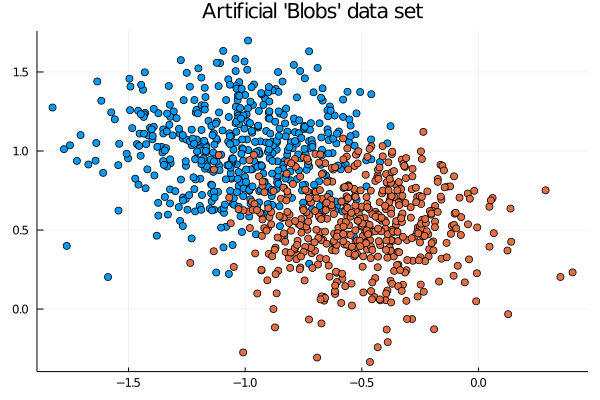

In [4]:
plot(X[:,1], X[:,2], group=y,
     seriestype = :scatter, 
     title = "Artificial 'Blobs' data set", 
     legend=false)

In [5]:
X_train = cat(X, ones(1000),dims=2); # Append biases

## Base Functions
Here we will implement all the functions found in <a href="https://yhat.tech//maths-of-logistic-regression/">the previous post</a>.

We start by making a `struct` for the logistic regression (weights) and the initialisation function.

In [6]:
struct logreg
    θ::Vector{Real}
end

initialise(X::Array) = logreg(rand(-1:1e-5:1, size(X)[2]))

initialise (generic function with 1 method)

We start with the sigmoid:

\begin{equation}
\mathcal{g}(\alpha) = \frac{1}{1 + e^{-\alpha}}
\end{equation}

In [7]:
sigmoid(α) = 1/(1 + exp(-α))

sigmoid (generic function with 1 method)

Now we can implement our (raw) prediction functions:

\begin{equation}
\mathcal{f}_\theta(x) = \mathcal{g}(\mathbf{\theta}^{\top} \mathbf{x})
\end{equation}

In [8]:
raw_predict(m::logreg, x) = sigmoid(dot(m.θ, x))
raw_predict_all(m::logreg, X) = dropdims(mapslices(x->raw_predict(m, x), X, dims=2),dims=2)

predict(m::logreg, x) = raw_predict(m, x) >= .5
predict_all(m::logreg, x) = raw_predict_all(m, x) .>= .5

predict_all (generic function with 1 method)

The cross-entropy loss:
\begin{equation}
-\sum_{i=1}^N {y^i} \log h_{\theta}(\mathbf{x}_i) + (1-y^i) \log \left(1-h_{\theta}(\mathbf{x}_i)\right) 
\end{equation}

In [9]:
crossentropy(m::logreg, X::Array, y::Array) = -sum(y.*log.(raw_predict_all(m, X))+(1 .- y).*log.(1 .- raw_predict_all(m, X)))

crossentropy (generic function with 1 method)

And let's add a simple accuracy function:

In [10]:
accuracy(m::logreg, X::Array, y::Array) = sum(predict_all(m, X).==y)/size(X)[1]

accuracy (generic function with 1 method)

Our training equations:
\begin{equation}
    \mathbf{\theta}_{t+1} = \mathbf{\theta}_{t} – \alpha \nabla L(\theta)
\end{equation}
\begin{equation}
\frac{\delta L(\mathbf{\theta})}{\delta \mathbf{\theta}} = – \sum_{i=1}^N [y_i – h_\theta(\mathbf{x}_i)]\mathbf{x}_i
\end{equation}

In [11]:
function train(m::logreg, X, y, α)
    dL = -sum((y.-raw_predict_all(m, X)).*X, dims=1)
    m.θ .-= α.*dropdims(dL, dims=1)
end

train (generic function with 1 method)

Let's try out the functions on an untrained logistic regression:

In [12]:
classifier = initialise(X_train)
@show raw_predict(classifier, X_train[1,:])
@show predict(classifier, X_train[1,:])
@show accuracy(classifier, X_train, y)
@show crossentropy(classifier, X_train, y)

raw_predict(classifier, X_train[1, :]) = 0.7154434080638887
predict(classifier, X_train[1, :]) = true
accuracy(classifier, X_train, y) = 0.5
crossentropy(classifier, X_train, y) = 799.4872303037138


799.4872303037138

## AutoDiff Training Illustrated

In [13]:
n_epochs = 100
losses = zeros(n_epochs)
accuracies = zeros(n_epochs)

for iteration in 1:n_epochs
    train(classifier, X_train, y, 1/n_samples)
    
    # Store epoch scores
    losses[iteration] = crossentropy(classifier, X_train, y)
    accuracies[iteration] = accuracy(classifier, X_train, y)
end

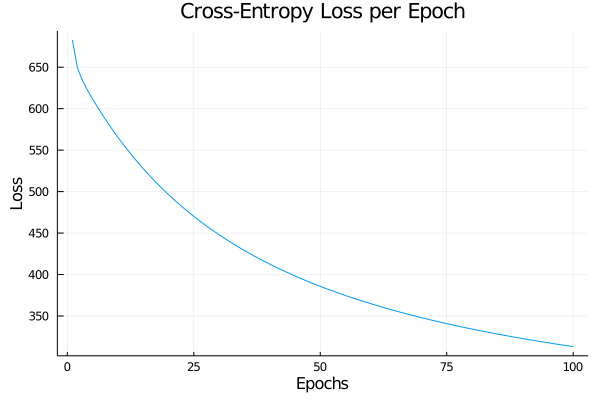

In [14]:
plot(1:100, losses,
    title="Cross-Entropy Loss per Epoch",
    xaxis="Epochs",
    yaxis="Loss",
    legend=false)

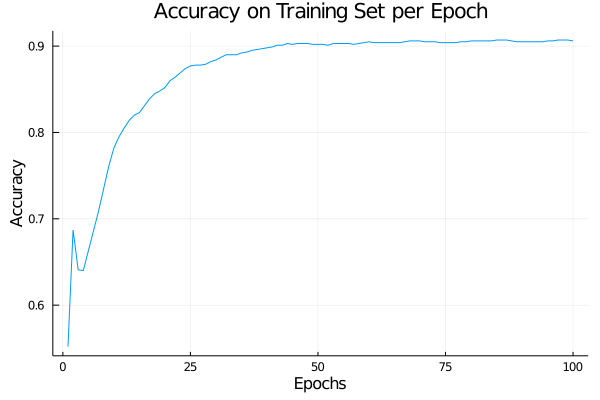

In [15]:
plot(1:100, accuracies,
    title="Accuracy on Training Set per Epoch",
    xaxis="Epochs",
    yaxis="Accuracy",
    legend=false)

### Visualising Decision Boundary Search

In [16]:
dec_boundary(x_1, x_2) = sigmoid(sum([classifier.θ[1]*x_1, classifier.θ[2]*x_2,classifier.θ[3]])) >= .5
x_axis = -1.5:0.001:0.5
y_axis = -0.5:0.001:2;

┌ Info: Saved animation to 
│   fn = C:\Users\Axel9\OneDrive\Projecten\201203_Einsum\dec_boundary.gif
└ @ Plots C:\Users\Axel9\.julia\packages\Plots\jZRxE\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Axel9\\OneDrive\\Projecten\\201203_Einsum\\dec_boundary.gif")
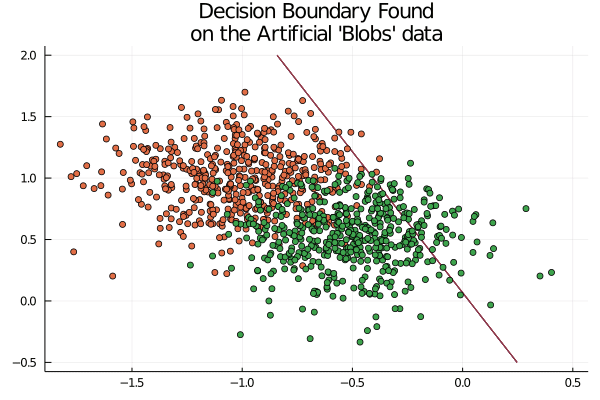

In [17]:
classifier = initialise(X_train)

plot(X[:,1], X[:,2], group=y,
         seriestype = :scatter, 
         title = "Decision Boundary Found\non the Artificial 'Blobs' data", 
         legend=false)

anim = @animate for iteration in 1:100
    train(classifier, X_train, y, 1/size(X_train)[1])
    contour(x_axis, y_axis, dec_boundary, legend=false)
    plot!(X_train[:,1], X_train[:,2], group=y,
         seriestype = :scatter, 
         title = "Decision Boundary Found\non the Artificial 'Blobs' data", 
         legend=false)
end

gif(anim, "dec_boundary.gif", fps = 100)